# First Architecture

This is a simple perceptron architecture with only one layer.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Load Data

In [2]:
df_train = pd.read_csv('data/raw/lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [3]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [4]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [25]:
def get_values_from_category(df_train, n_samples=1000):
    '''
    Get the same values (or all if it has less than) of all categories. The idea is to balance dataset
    '''

    df_data = pd.DataFrame()

    for cat in df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.unique():
        df_data = df_data.append(df_train[df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT == cat].iloc[0:n_samples])
    
    return df_data

df_partial_data = get_values_from_category(df_train)
df_partial_data.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [26]:
df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Anhydrite          1000
Marl               1000
Shale              1000
Dolomite           1000
Sandstone/Shale    1000
Sandstone          1000
Coal               1000
Tuff               1000
Chalk              1000
Limestone          1000
Halite             1000
Basement            103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

### Split X and Y

In [27]:
X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

def transform_data(X_train, X_test, y_train, y_test):
    std = StandardScaler()
    oe = OrdinalEncoder()

    X_train_transform = std.fit_transform(X_train)
    X_test_transform = std.transform(X_test)

    y_train_enc = oe.fit_transform(y_train)
    y_test_enc = oe.transform(y_test)

    return X_train_transform, X_test_transform, y_train_enc, y_test_enc

X_train_transform, X_test_transform, y_train_transform, y_test_transform = transform_data(X_train, X_test, y_train, y_test)

torch.Size([8327, 30])
torch.Size([8327])
Cost Graphic


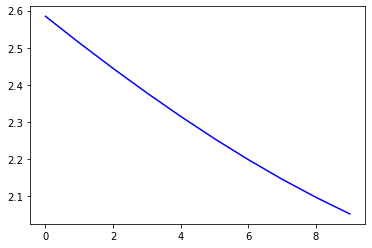

In [71]:
class RegressaoSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(RegressaoSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

def load_model(
    X_train, X_test, y_train, y_test, 
    num_epochs=1000, input_size=1, 
    output_size=12, learning_rate=0.05):
    
    x = torch.from_numpy(X_train.astype(np.float32))
    y = torch.from_numpy(y_train.reshape(-1).astype(np.float32))
    y = y.long()
    x = x.view(x.shape[0], input_size)    

    model = RegressaoSoftmax(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    contador_custo = []
    for epoch in range(num_epochs):
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        loss = loss.detach().numpy()
        contador_custo.append(loss)
        optimizer.step()
        optimizer.zero_grad()

    

    print("Cost Graphic")
    plt.plot(contador_custo, 'b')
    plt.show()
    
    # t_teste = torch.from_numpy(teste.astype(np.float32))
    # t_teste = t_teste.view(t_teste.shape[0], 1)

    # with torch.no_grad():
    # predicoes = model(t_teste)
    # print (np.argmax(predicoes, axis=1).flatten())

load_model(
    X_train_transform, X_test_transform, 
    y_train_transform, y_test_transform,
    input_size=30, num_epochs=10)